<a href="https://www.kaggle.com/code/sagorkumarmitra/image-classification-from-scratch?scriptVersionId=148297580" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data loading

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   116M      0  0:00:06  0:00:06 --:--:--  117M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip
 PetImages		  'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


# Preprocessing

In [5]:
import os
num_skipped=0
for folder_name in ("Cat","Dog"):
    folder_path=os.path.join("PetImages",folder_name)
    for fname in os.listdir(folder_path):

        fpath=os.path.join(folder_path,fname)
        try:
            fobj=open(fpath,"rb")
            is_jfif=tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
    print("Deleted %d images" % num_skipped)

Deleted 759 images
Deleted 1590 images


# Clean Dataset

In [6]:
image_size=(180,180)
batch_size=128
train_ds,val_ds=tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


# Visualization

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


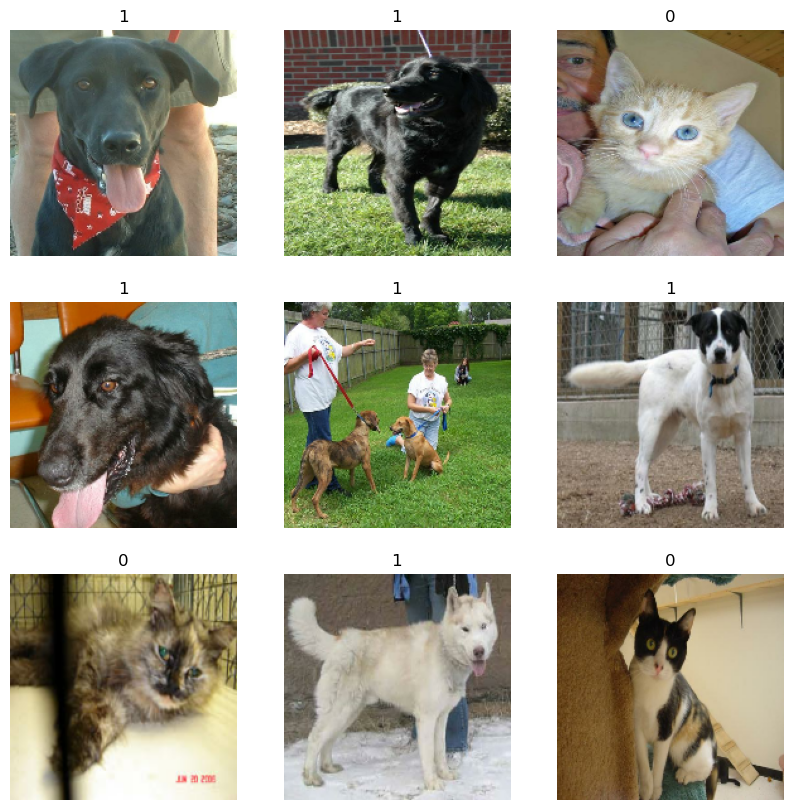

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in  range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data augmentation

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


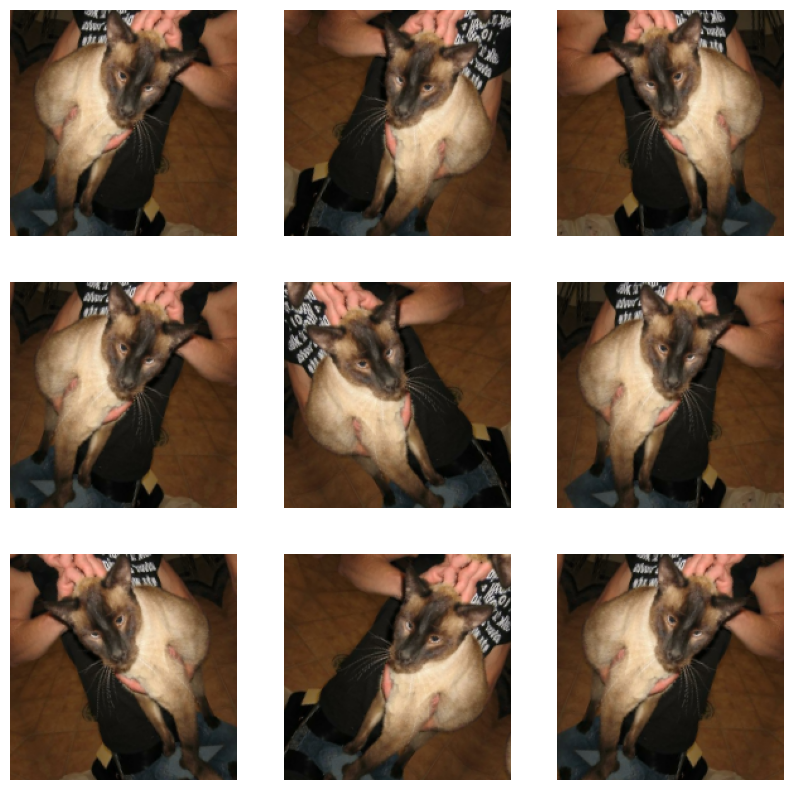

In [8]:
data_augmentation=keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        augmented_images=data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Standardizing the data

In [9]:
train_ds=train_ds.map(
    lambda img,label: (data_augmentation(img),label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds=train_ds.prefetch(tf.data.AUTOTUNE)
val_ds=val_ds.prefetch(tf.data.AUTOTUNE)

# Build a model

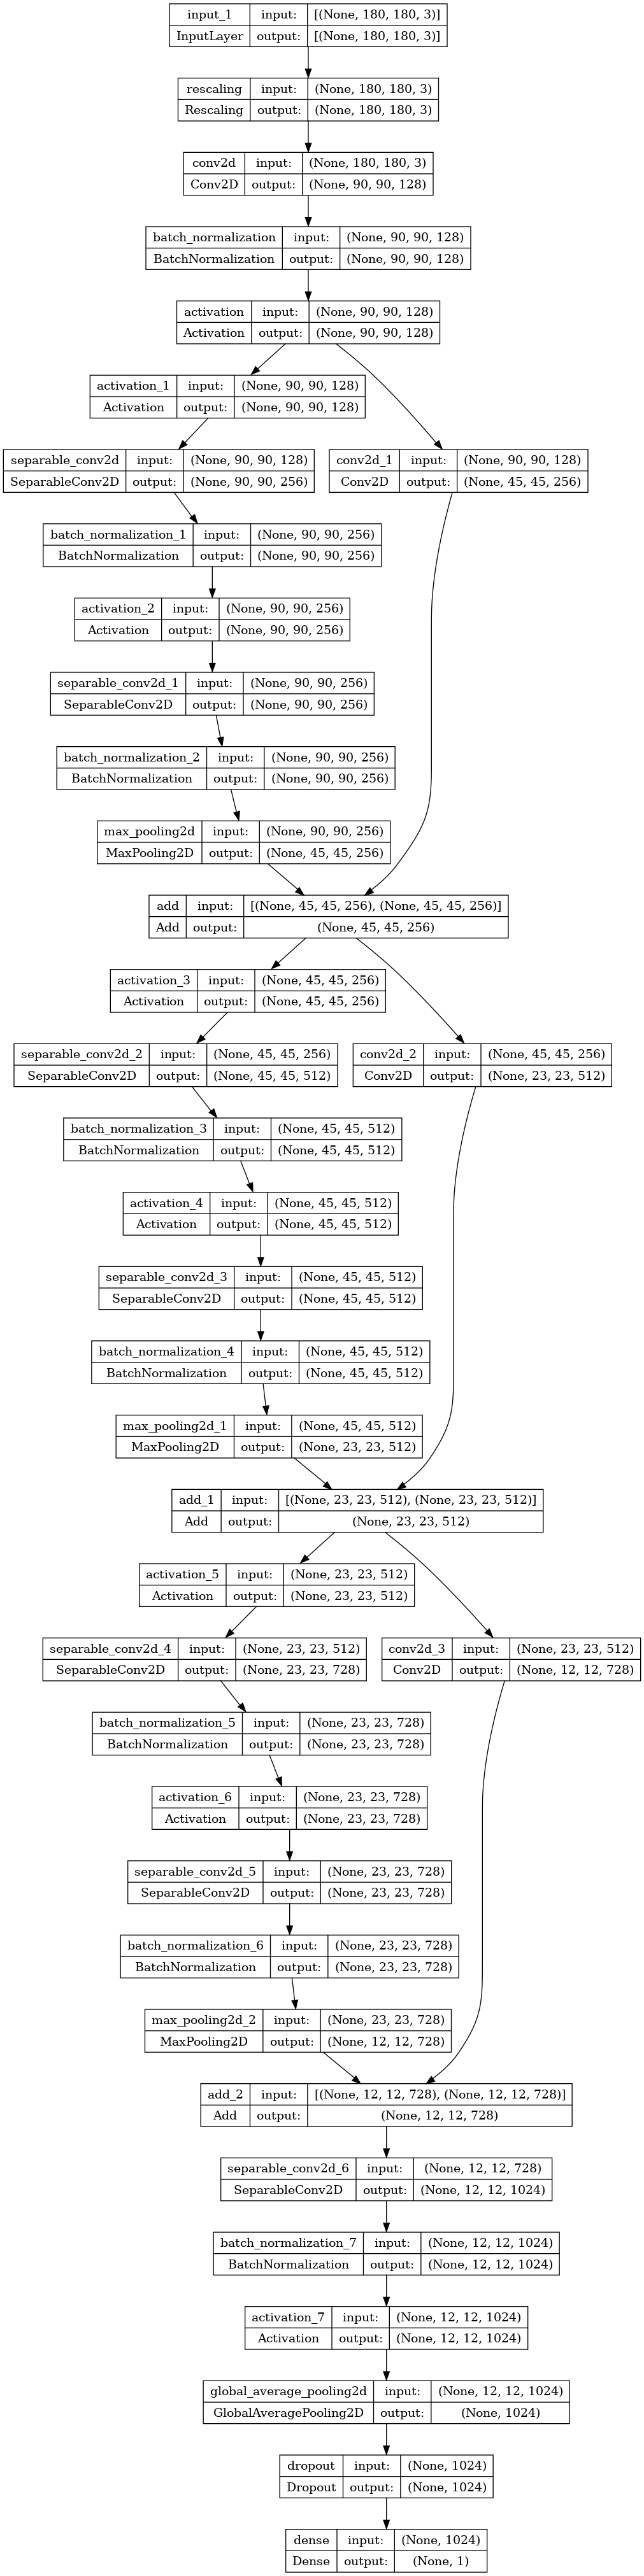

In [10]:
def make_model(input_shape,num_classes):
    inputs=keras.Input(shape=input_shape)
    
    #Entry block
    x=layers.Rescaling(1/255)(inputs)
    x=layers.Conv2D(128,3,strides=2,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)
    
    previous_block_activation=x
    
    for size in [256,512,728]:
        x=layers.Activation("relu")(x)
        x=layers.SeparableConv2D(size,3,padding="same")(x)
        x=layers.BatchNormalization()(x)
        
        x=layers.Activation("relu")(x)
        x=layers.SeparableConv2D(size,3,padding="same")(x)
        x=layers.BatchNormalization()(x)
        
        x=layers.MaxPooling2D(3,strides=2,padding="same")(x)
        
        # Project residual
        residual=layers.Conv2D(size,1,strides=2,padding="same")(
            previous_block_activation
        )
        x=layers.add([x,residual])
        previous_block_activation = x
        
    x=layers.SeparableConv2D(1024,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)
    
    x=layers.GlobalAveragePooling2D()(x)
    if num_classes==2:
        activation="sigmoid"
        units=1
    else:
        activation="softmax"
        units=num_classes
        
    x=layers.Dropout(0.5)(x)
    outputs = layers.Dense(units,activation=activation)(x)
    return keras.Model(inputs,outputs)

model=make_model(input_shape=image_size + (3,),num_classes=2)
keras.utils.plot_model(model,show_shapes=True)

# Train the model

In [ ]:
epochs=25
callbacks=[
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:38 - loss: 0.6897 - accuracy: 0.6067

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:29 - loss: 0.6835 - accuracy: 0.6098

 96/147 [==================>...........] - ETA: 1:05 - loss: 0.6666 - accuracy: 0.6241

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 1:01 - loss: 0.6663 - accuracy: 0.6252

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 57s - loss: 0.6628 - accuracy: 0.6281

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 56s - loss: 0.6630 - accuracy: 0.6280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.6514

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 242s 1s/step - loss: 0.6376 - accuracy: 0.6514 - val_loss: 0.7940 - val_accuracy: 0.4957
Epoch 2/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:41 - loss: 0.5210 - accuracy: 0.7425

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:31 - loss: 0.5153 - accuracy: 0.7478

 96/147 [==================>...........] - ETA: 1:06 - loss: 0.5077 - accuracy: 0.7540

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 1:02 - loss: 0.5065 - accuracy: 0.7554

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 58s - loss: 0.5050 - accuracy: 0.7567

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 57s - loss: 0.5039 - accuracy: 0.7577

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.7701

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 206s 1s/step - loss: 0.4840 - accuracy: 0.7701 - val_loss: 1.3087 - val_accuracy: 0.4957
Epoch 3/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:41 - loss: 0.4066 - accuracy: 0.8190

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:31 - loss: 0.4047 - accuracy: 0.8202

 96/147 [==================>...........] - ETA: 1:06 - loss: 0.4015 - accuracy: 0.8222

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 1:02 - loss: 0.4000 - accuracy: 0.8228

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 58s - loss: 0.3976 - accuracy: 0.8241 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 57s - loss: 0.3974 - accuracy: 0.8243

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8330

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 206s 1s/step - loss: 0.3794 - accuracy: 0.8330 - val_loss: 1.3035 - val_accuracy: 0.4957
Epoch 4/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:41 - loss: 0.3272 - accuracy: 0.8615

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:31 - loss: 0.3253 - accuracy: 0.8629

 96/147 [==================>...........] - ETA: 1:06 - loss: 0.3251 - accuracy: 0.8625

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 1:02 - loss: 0.3239 - accuracy: 0.8629

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 58s - loss: 0.3221 - accuracy: 0.8637

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 57s - loss: 0.3225 - accuracy: 0.8636

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.8652

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 206s 1s/step - loss: 0.3159 - accuracy: 0.8652 - val_loss: 0.4438 - val_accuracy: 0.7772
Epoch 5/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:41 - loss: 0.2618 - accuracy: 0.8887

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:31 - loss: 0.2631 - accuracy: 0.8886

 96/147 [==================>...........] - ETA: 1:06 - loss: 0.2637 - accuracy: 0.8885

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 1:02 - loss: 0.2631 - accuracy: 0.8883

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 58s - loss: 0.2628 - accuracy: 0.8889 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 57s - loss: 0.2624 - accuracy: 0.8889

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.8921

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 206s 1s/step - loss: 0.2567 - accuracy: 0.8921 - val_loss: 0.2507 - val_accuracy: 0.8947
Epoch 6/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 26/147 [====>.........................] - ETA: 2:37 - loss: 0.2415 - accuracy: 0.9062

# Run inference on new data

In [ ]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")